In [4]:
from __future__ import print_function
import torch, os, gym, time, glob, argparse, sys
import numpy as np
from scipy.signal import lfilter
from scipy.misc import imresize # preserves single-pixel info _unlike_ img = img[::2,::2]
import torch.nn as nn
import torch.nn.functional as F
import torch.multiprocessing as mp

In [6]:
class NNPolicy(torch.nn.Module): # an actor-critic neural network
    
    def __init__(self, channels, memsize, num_actions):
        super(NNPolicy, self).__init__()
        self.conv1 = nn.Conv2d(channels, 32, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 32, 3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(32, 32, 3, stride=2, padding=1)
        self.gru = nn.GRUCell(32 * 5 * 5, memsize)
        self.critic_linear, self.actor_linear = nn.Linear(memsize, 1), nn.Linear(memsize, num_actions)

    def forward(self, inputs, train=True, hard=False):
        inputs, hx = inputs
        x = F.elu(self.conv1(inputs))
        x = F.elu(self.conv2(x))
        x = F.elu(self.conv3(x))
        x = F.elu(self.conv4(x))
        hx = self.gru(x.view(-1, 32 * 5 * 5), (hx))
        return self.critic_linear(hx), self.actor_linear(hx), hx

    def try_load(self, save_dir, checkpoint='*.tar'):
        paths = glob.glob(save_dir + checkpoint) ; step = 0
        if len(paths) > 0:
            ckpts = [int(s.split('.')[-2]) for s in paths]
            ix = np.argmax(ckpts) ; step = ckpts[ix]
            self.load_state_dict(torch.load(paths[ix]))
        print("\tno saved models") if step is 0 else print("\tloaded model: {}".format(paths[ix]))
        return step

In [7]:
from torch.autograd import Variable
prepro = lambda img: imresize(img[35:195].mean(2), (80,80)).astype(np.float32).reshape(1,80,80)/255.

In [9]:
save_dir ="weights/Space_inv/"
env = gym.make('SpaceInvaders-v4')
num_actions = env.action_space.n # get the action space of this game
prepro = lambda img: imresize(img[35:195].mean(2), (80,80)).astype(np.float32).reshape(1,80,80)/255.


model = NNPolicy(channels=1, memsize=256, num_actions=num_actions)
model.try_load(save_dir)
hx = Variable(torch.zeros(1, 256))
state = env.reset()

	loaded model: weights/Space_inv\model.80.tar


In [12]:
from IPython import display
import matplotlib
import matplotlib.pyplot as plt

def get_frames_and_features(env, model, nb_steps=1000):
    
    features_list = []
    action_list = []
    value_list = []
    frames = []
    while nb_steps > 0:
        state = env.reset()
        frames.append(state)
        state = torch.tensor(prepro(state))
        done = False
        hx, cx = Variable(torch.zeros(1, 256)), Variable(torch.zeros(1, 256))
        print (nb_steps)
        while True:

            x = state.view(1,1,80,80)
            value, logit, hx = model((x, hx))
            logp = F.log_softmax(logit, dim=-1)
            action = torch.exp(logp).multinomial(num_samples=1).data[0]
            action_list.append(action)
            value_list.append(value)
            next_state, reward, done, _ = env.step(action)
            frames.append(next_state)
            features = hx[0].detach().numpy()
            features_list.append(features)
            state = torch.tensor(prepro(next_state))
            nb_steps -= 1
            if nb_steps < 0 or done:
                break
    
    return features_list, action_list, value_list, frames

In [13]:
features_list, actions_list, value_list, frames = get_frames_and_features(env, model, 10000)
from sklearn.decomposition import PCA
pca = PCA(n_components=40)
pca_features = pca.fit_transform(features_list)

C:\Users\User\Anaconda3\envs\RL_vizu\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


10000
9271
8619
7348
6402
5466
4145
3228
2428
1266
629


In [34]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=80, n_iter=300)
tsne_results = tsne.fit_transform(pca_features)
tsne_results.shape

[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 10001 samples in 0.024s...
[t-SNE] Computed neighbors for 10001 samples in 2.936s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10001
[t-SNE] Computed conditional probabilities for sample 2000 / 10001
[t-SNE] Computed conditional probabilities for sample 3000 / 10001
[t-SNE] Computed conditional probabilities for sample 4000 / 10001
[t-SNE] Computed conditional probabilities for sample 5000 / 10001
[t-SNE] Computed conditional probabilities for sample 6000 / 10001
[t-SNE] Computed conditional probabilities for sample 7000 / 10001
[t-SNE] Computed conditional probabilities for sample 8000 / 10001
[t-SNE] Computed conditional probabilities for sample 9000 / 10001
[t-SNE] Computed conditional probabilities for sample 10000 / 10001
[t-SNE] Computed conditional probabilities for sample 10001 / 10001
[t-SNE] Mean sigma: 0.289513
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.775475
[t-SNE] KL

(10001, 2)

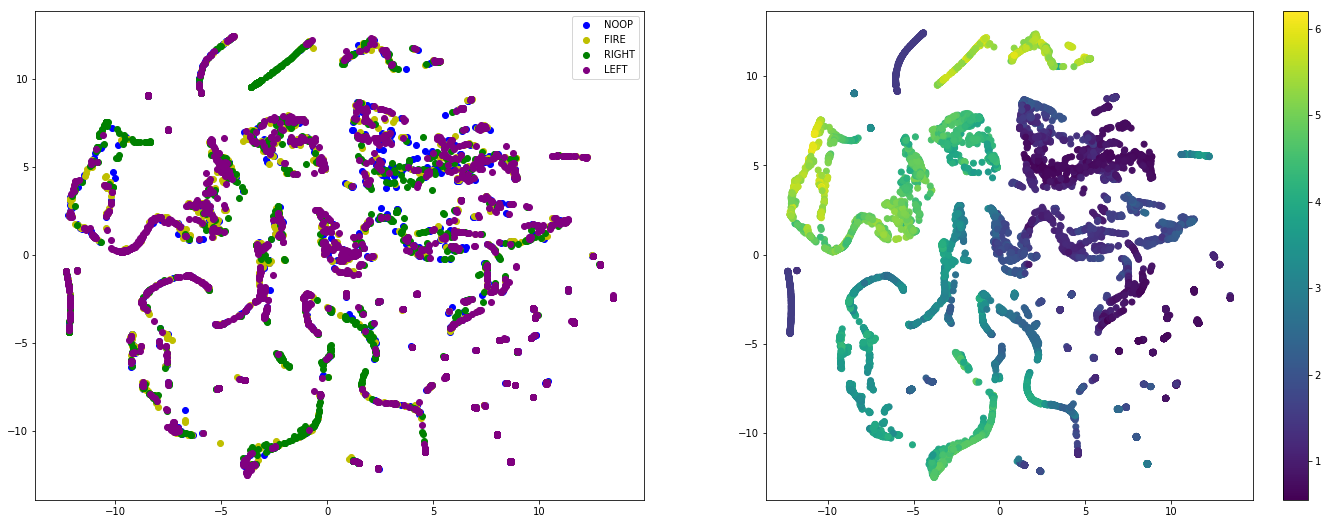

In [35]:
import matplotlib.pyplot as plt
actions = env.unwrapped.get_action_meanings()
colors = ['b','y','green', 'purple']
plt.figure(figsize=(24,9))
plt.subplot(1,2,1)
for i in [0,1,2,3]:
    x = [tsne_results[:,0][index]  for index in range(len(actions_list)) if actions_list[index] == i]
    y = [tsne_results[:,1][index]  for index in range(len(actions_list)) if actions_list[index] == i]
    plt.scatter(x, y, c=colors[i], label=actions[i])
plt.legend()
plt.subplot(1,2,2)
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=value_list)
plt.colorbar()

In [21]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy.misc import imread, imresize

def imscatter(x, y, frames, ax=None, zoom=1, linewidth=0):
    if ax is None:
        ax = plt.gca()
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0, frame in zip(x, y, frames):
        try:
            im = frame
        except:
            print(p)
            continue
        im = imresize(im,(250,180))
        im = OffsetImage(im, zoom=zoom)
        ab = AnnotationBbox(im, (x0, y0), xycoords='data',
                            frameon=True, pad=0.1, 
                            bboxprops=dict(edgecolor='red',
                                           linewidth=linewidth))
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

In [17]:
frames2 = frames.copy()
for i in range(3, len(frames)):
    frames2[i] = frames[i] + 0.4* frames[i-1] + 0.4* frames[i-2] + 0.4* frames[i-3]

C:\Users\User\Anaconda3\envs\RL_vizu\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


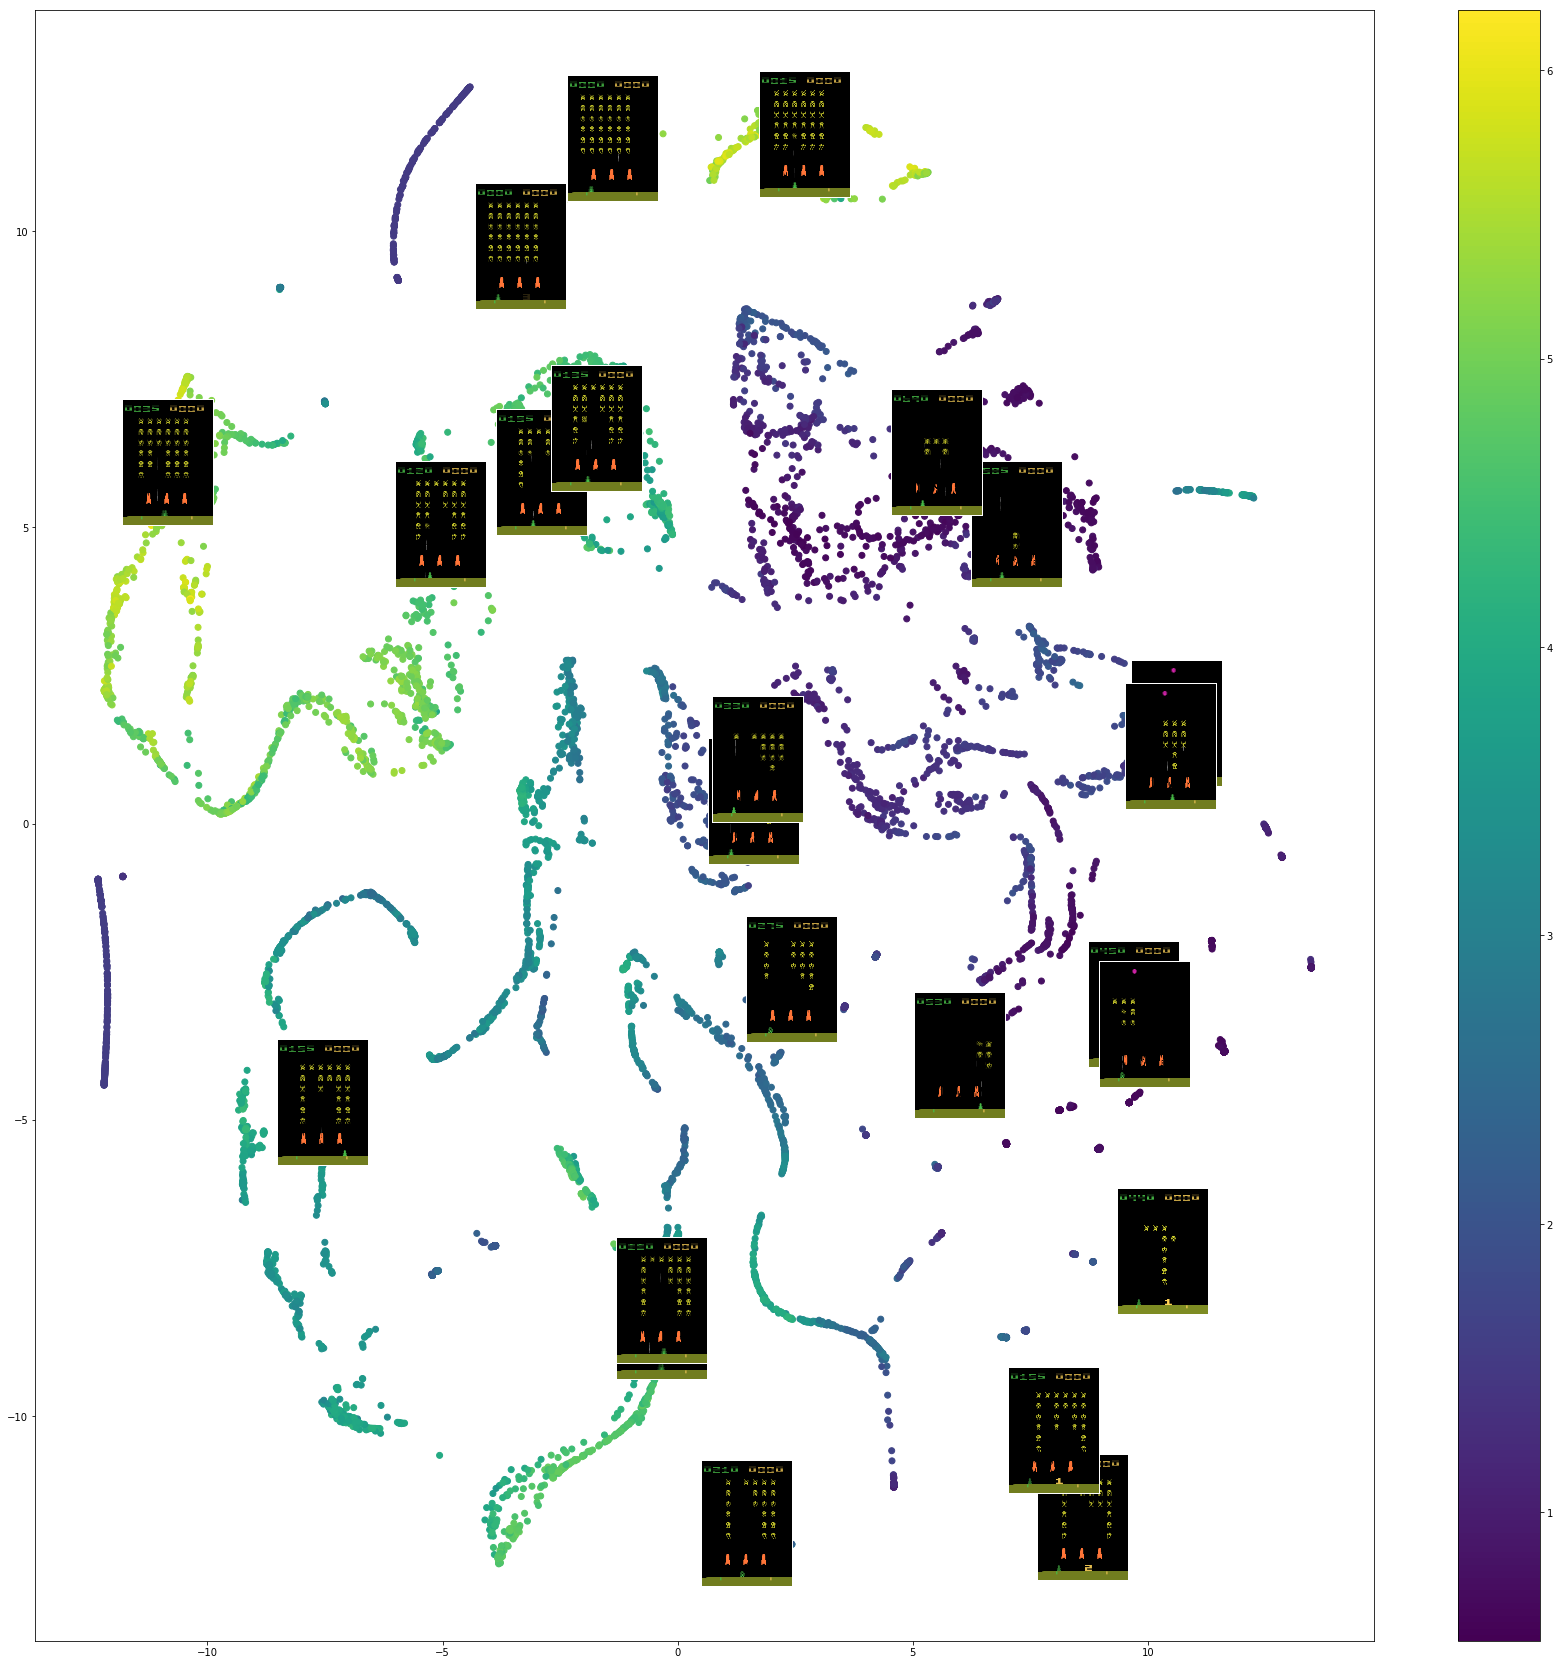

In [43]:
import random
l =range(len(tsne_results[:,0]))
ind = random.sample(l, 25)

imx = [tsne_results[:,0][index] for index in ind]
imy = [tsne_results[:,1][index] for index in ind]
im_fig = [frames2[index] for index in ind]

fig, ax = plt.subplots(figsize=(30, 30))
imscatter(imx, imy, im_fig, zoom=0.5, ax=ax);
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=value_list)
plt.colorbar()

C:\Users\User\Anaconda3\envs\RL_vizu\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


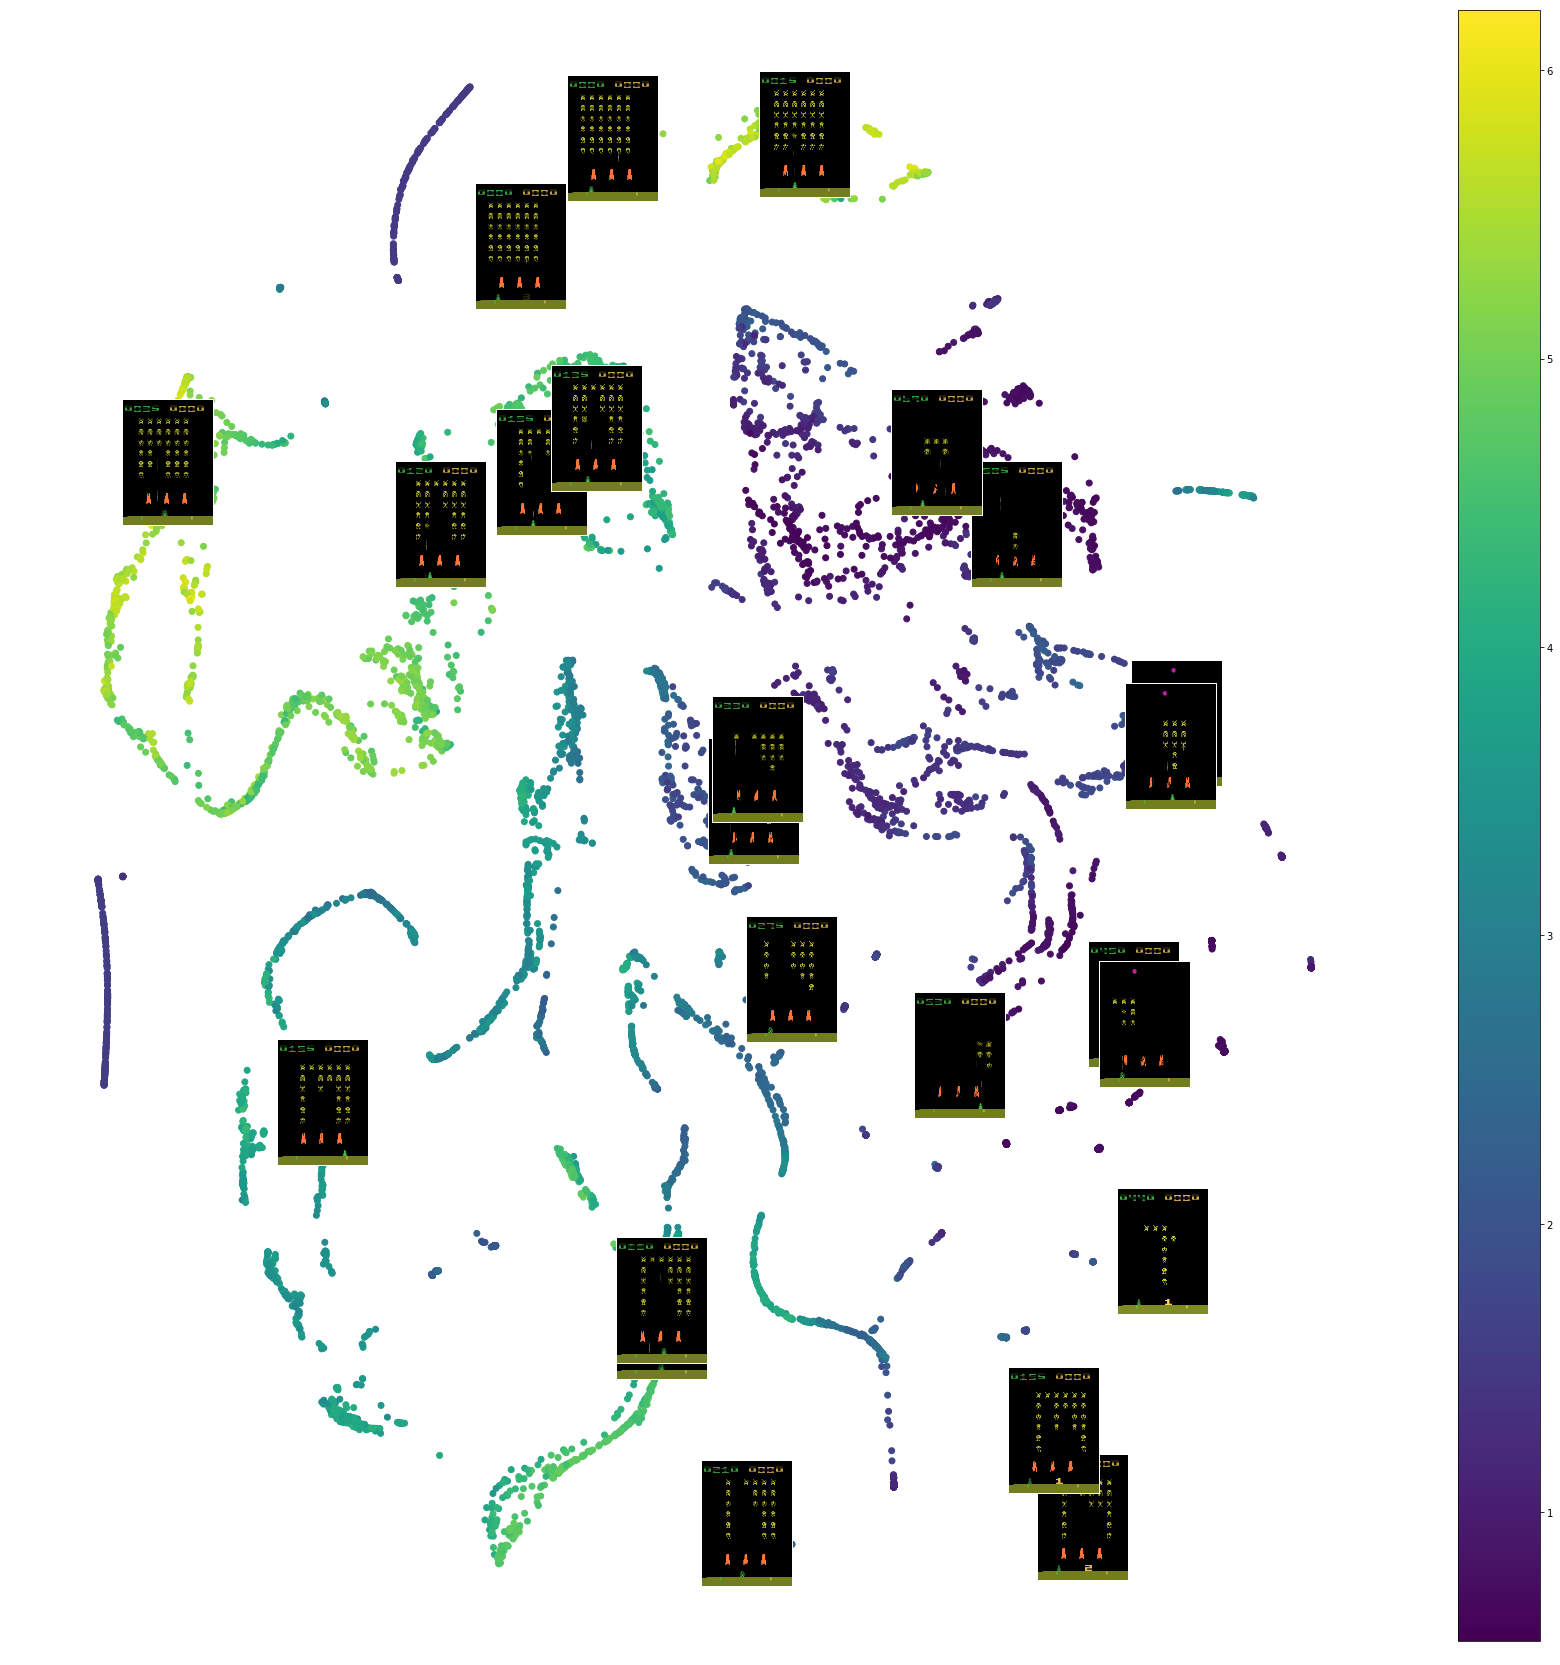

In [44]:
fig, ax = plt.subplots(figsize=(30, 30))
imscatter(imx, imy, im_fig, zoom=0.5, ax=ax);
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=value_list)
plt.colorbar()
plt.axis('off')
plt.savefig("tsne_a3c_space_inv.png", bbox_inches='tight')

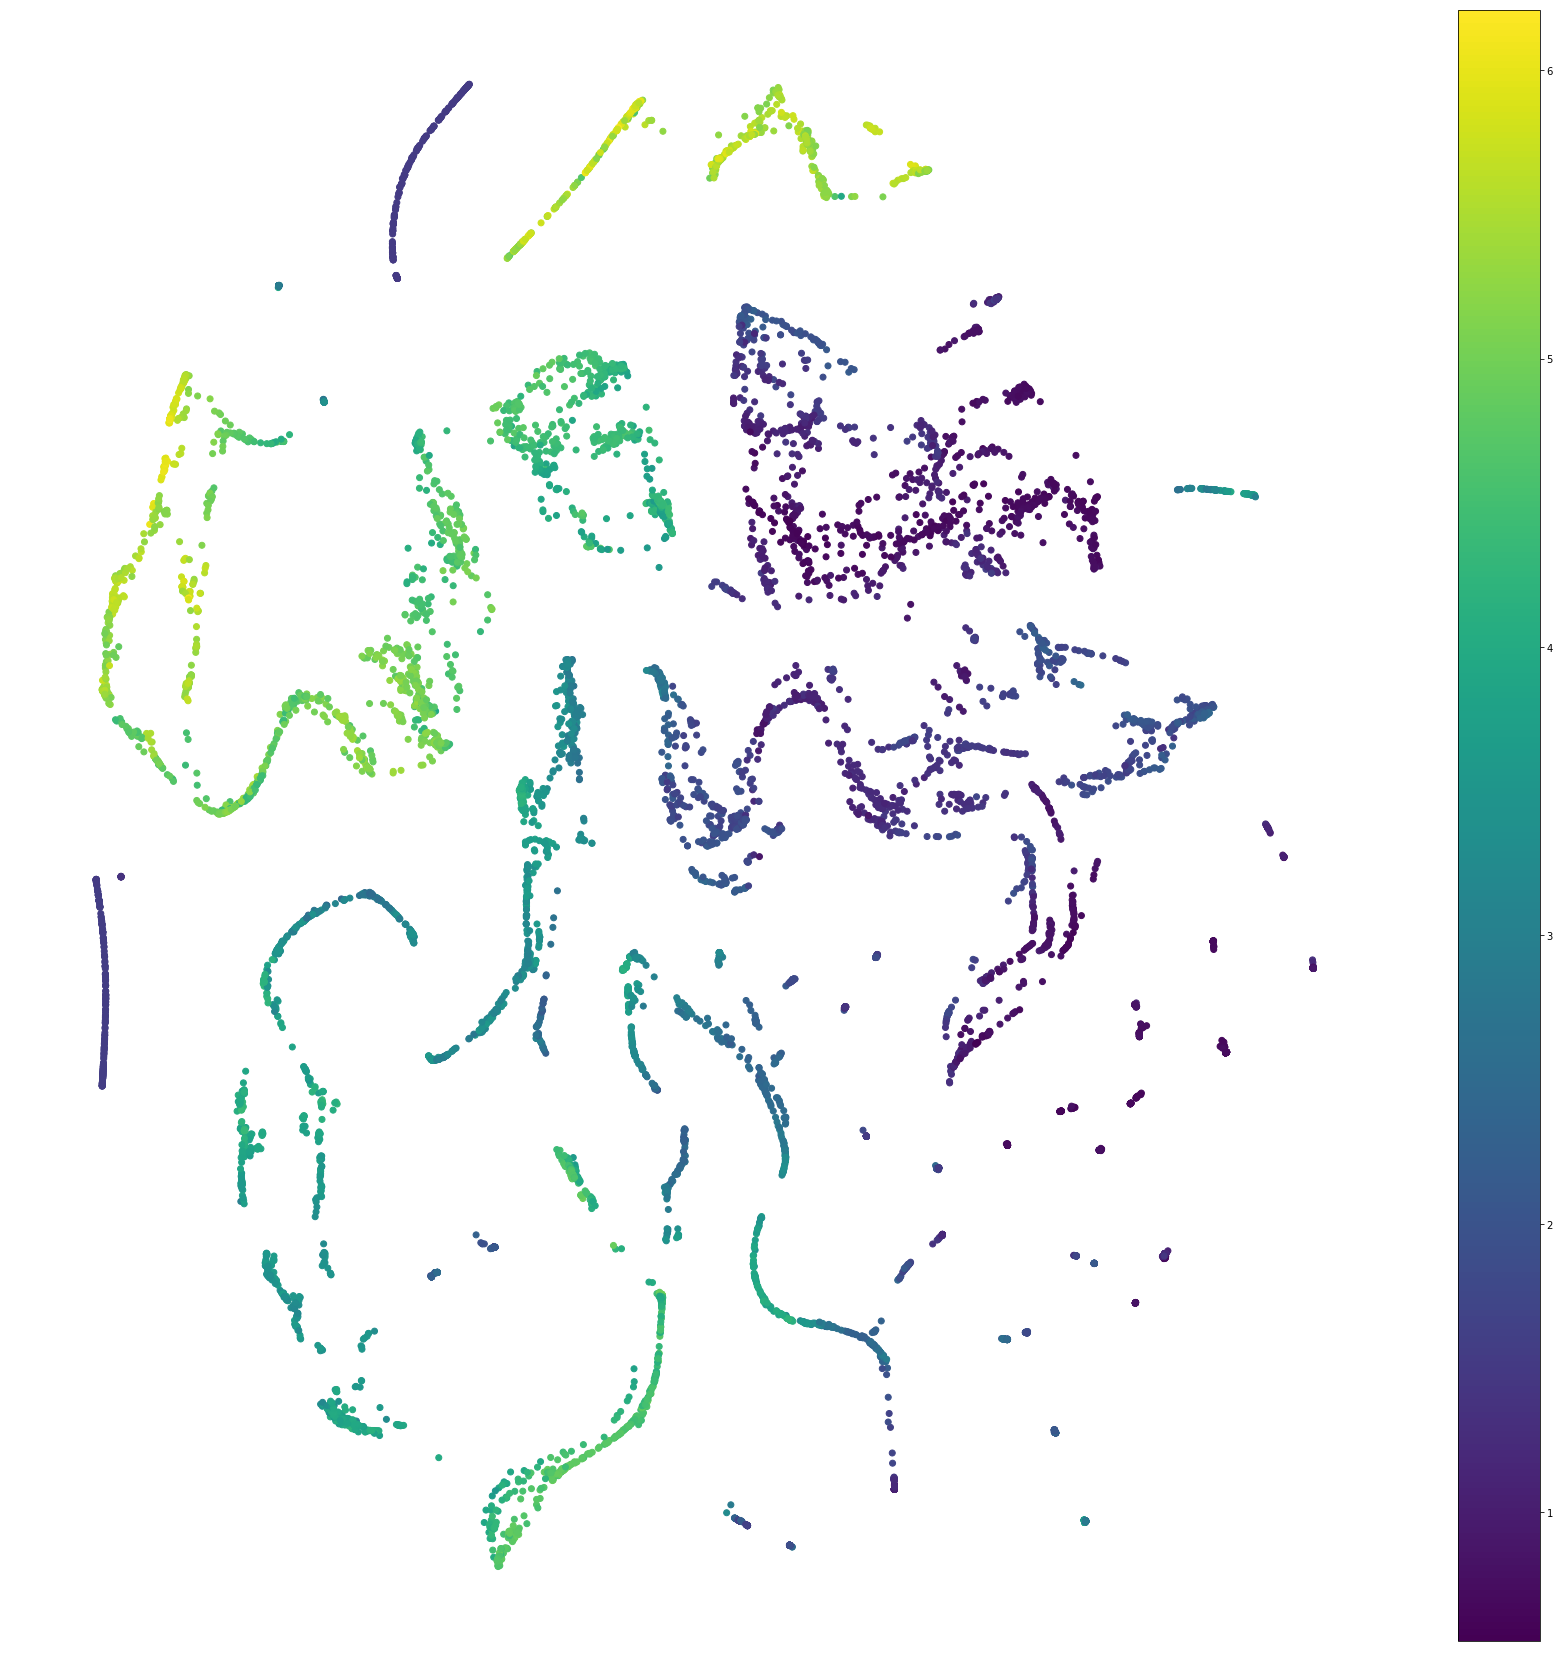

In [45]:
fig, ax = plt.subplots(figsize=(30, 30))
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=value_list)
plt.colorbar()
plt.axis('off')
plt.savefig("tsne_a3c_space_inv_no_images.png", bbox_inches='tight')